# Batch Normalization Keras
Normalize each batch by both mean and variance reference
### Purpose
As the data flows through a deep network, the weights and parameters adjust those values, sometimes making the data too big or too small again - a problem the authors refer to as "internal covariate shift". By normalizing the data in each mini-batch, this problem is largely avoided.

### Benefits:
- Networks train faster converge much more quickly,
- Allows higher learning rates Gradient descent usually requires small learning rates for the network to converge.
- Makes weights easier to initialize
- Makes more activation functions viable Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.
- May give better results overall  it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better.

### Keypoints
- Batch normalization uses weights as usual, but does NOT add a bias term. This is because, its calculations include gamma and beta variables that make the bias term unnecessary. In Keras `Dense(64, use_bias=False)` or `Conv2D(32, (3, 3), use_bias=False)`
- We add the normalization before calling the activation function.


In [1]:
from tensorflow.python import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

keras.__version__

'2.2.4-tf'

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)  # one-hot
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 1s 0us/step


In [3]:
def data_generator(x, y, batch_size=32):
    batches = int(len(x)/batch_size)
    while 1:
        for i in range(batches):
            yield x[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]

In [4]:
img_size=(28, 28, 1)
class NeuralNet:
    def __init__(self, use_batch_norm, activation='relu'):
        self.use_batch_norm = use_batch_norm
        self.build_model(activation=activation)
    def add_dense_layer(self, units, activation='relu'):
        if self.use_batch_norm:
            self.model.add(layers.Dense(units, use_bias=False))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Dense(units, activation=activation))
    def add_conv2d_layer(self, filters, kernel_size, activation='relu', **kwargs):
        if self.use_batch_norm:
            self.model.add(layers.Conv2D(filters, kernel_size, use_bias=False, **kwargs))
            self.model.add(layers.BatchNormalization())
            self.model.add(layers.Activation(activation))
        else:
            self.model.add(layers.Conv2D(filters, kernel_size, activation=activation, **kwargs))
    def build_model(self, activation):
        self.model = models.Sequential()
        self.add_conv2d_layer(32, (3, 3), activation=activation, input_shape=img_size)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.add_conv2d_layer(64, (3, 3), activation=activation)
        self.model.add(layers.Flatten())
        self.add_dense_layer(64, activation=activation)
        self.add_dense_layer(10, activation='softmax')
    def train(self, learning_rate=0.001, epoches=40, batch_size=32, steps_per_epoch=30):
        self.model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
        history = self.model.fit_generator(generator=data_generator(train_images, train_labels, batch_size=batch_size),
                                      steps_per_epoch = steps_per_epoch,
                                      epochs = epoches,
                                      validation_data=data_generator(test_images, test_labels, batch_size=batch_size),
                                      validation_steps=len(test_images)/batch_size)
        return history.history

In [5]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `steps_per_epoch` is the only
        one we look for. It should match the `steps_per_epoch` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    steps_per_epoch = kwargs['steps_per_epoch']
    
    for history in args:
        ax.plot(range(0,len(history['acc'])*steps_per_epoch,steps_per_epoch),
                history['acc'], label="acc-" + history['name'])
        ax.plot(range(0,len(history['val_acc'])*steps_per_epoch,steps_per_epoch),
                history['val_acc'], label="val_acc-"+history['name'])
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy During Training')
    ax.legend(loc=4)
    #ax.set_ylim([0,1])
    #plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show()

    
def train_and_test(learning_rate=0.001, activation="relu", epochs=40, steps_per_epoch=30):
    nn = NeuralNet(use_batch_norm=False, activation=activation)
    bn = NeuralNet(use_batch_norm=True, activation=activation)
    history_nn = nn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_bn = bn.train(learning_rate=learning_rate, epoches=epochs, steps_per_epoch=steps_per_epoch)
    history_nn['name'] = "Without batch normalization"
    history_bn['name'] = "With batch normalization"
    plot_training_accuracies(history_nn, history_bn, steps_per_epoch=steps_per_epoch)

W1130 16:34:38.119404 25164 deprecation.py:506] From C:\Users\seeho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/3
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1472 - acc: 0.9548 - val_loss: 0.0709 - val_acc: 0.9763
Epoch 2/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0461 - acc: 0.9859 - val_loss: 0.0370 - val_acc: 0.9876
Epoch 3/3
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0331 - acc: 0.9898 - val_loss: 0.0486 - val_acc: 0.9868
Epoch 1/3
1875/1875 [==============================] - 71s 38ms/step - loss: 0.2670 - acc: 0.9631 - val_loss: 0.0726 - val_acc: 0.9868
Epoch 2/3
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0877 - acc: 0.9849 - val_loss: 0.0433 - val_acc: 0.9899
Epoch 3/3
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0480 - acc: 0.9912 - val_loss: 0.0383 - val_acc: 0.9895


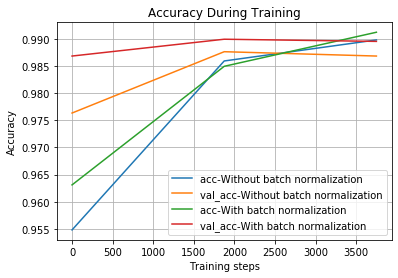

In [6]:
train_and_test(learning_rate=0.001, activation='relu', epochs=3, steps_per_epoch=1875)

Using a sigmoid activation function takes a long time to start learning. It eventually starts making progress, but it took over 250 batches just to get over 70% accuracy. Using batch normalization gets to 90% in around 100 batches.

Epoch 1/3
1875/1875 [==============================] - 42s 22ms/step - loss: 0.5811 - acc: 0.8142 - val_loss: 0.1262 - val_acc: 0.9633s - loss: 1.1934 - a - ETA:  - ETA: 22s - loss: 1.0664 - acc: 0.64 - ETA: 22s - lo - ETA: 19s - loss - E  - ETA: 2s - loss: 0.6174  - ETA: 2s - loss: 0.6068 - acc - ETA: 1s - lo
Epoch 2/3
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1026 - acc: 0.9696 - val_loss: 0.0874 - val_acc: 0.9727
Epoch 3/3
1875/1875 [==============================] - 52s 28ms/step - loss: 0.0670 - acc: 0.9797 - val_loss: 0.0847 - val_acc: 0.9741
Epoch 1/3
1875/1875 [==============================] - 74s 39ms/step - loss: 0.3273 - acc: 0.9506 - val_loss: 0.2174 - val_acc: 0.9579
Epoch 2/3
1875/1875 [==============================] - 70s 38ms/step - loss: 0.1344 - acc: 0.9732 - val_loss: 0.2383 - val_acc: 0.9341
Epoch 3/3
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0877 - acc: 0.9809 - val_loss: 0.1688 - val_acc: 0.9522


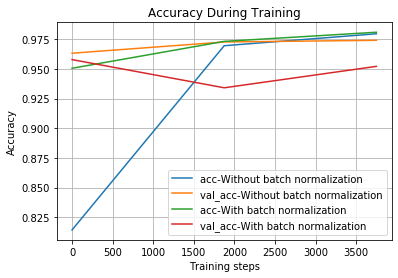

In [7]:
train_and_test(learning_rate=0.001, activation='sigmoid', epochs=3, steps_per_epoch=1875)

In [ ]:
train_and_test(learning_rate=0.01, activation='relu', epochs=3, steps_per_epoch=1875)

In [ ]:
train_and_test(learning_rate=0.01, activation='sigmoid', epochs=3, steps_per_epoch=1875)

In [ ]:
train_and_test(learning_rate=0.05, activation='relu', epochs=3, steps_per_epoch=1875)

In [ ]:
train_and_test(learning_rate=0.05, activation='sigmoid', epochs=3, steps_per_epoch=1875)

Try a smaller steps per epoch

In [ ]:
train_and_test(learning_rate=0.001, activation='relu', epochs=10, steps_per_epoch=int(1875/10))